<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 7 Day 2</div>
<div style="text-align: right">Dino Konstantopoulos, 14 October 2019</div>

Instead of doing something new today, I decided I would help you on your homework :-)

What happens if you can't get your hands on a dataset, and you need to scrape data from a web site? This notebook teaches you how to do it.

# Bayesian Baseball analytics

I found this beautiful baseball results Web site, [fangraphs](https://www.fangraphs.com/). Let's scape some data (probably better to use the Tom Brady sport analytics package, tho).

I will concentrate on **attack** and **defense** as independent parameters. **Batting** for attack, and I will neglect **Fielding** in defense and concentrate solely on **pitching**. This is not good, but i'm professor, so I can do that (you can't).

</br >
<center>
<img src="images/calvin-grin.jpg" width=200 />
</center>

I also ***won't*** consider *all* players on the team, there's ***too many of them***. Moreover, many players remain on the bench and some (like pitchers) are on a rotation and play only every 5 games or so.

# Getting the data

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

Scraping Web pages with `Beautiful soup`:

In [19]:
def get_soup_team_pitching(season):
    url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=8&season=2019&month=0&season1=" + str(season) + "&ind=0&team=0,ts&rost=0&age=0&filter=&players=0"
    s=requests.get(url).content
    #print(s)
    return BeautifulSoup(s, "lxml")

In [20]:
def get_soup_team_batting(season):
    url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=8&season=2019&month=0&season1=" + str(season) + "&ind=0&team=0,ts&rost=0&age=0&filter=&players=0&startdate=&enddate="
    s=requests.get(url).content
    #print(s)
    return BeautifulSoup(s, "lxml")

In [21]:
def get_soup_players_pitching(season):
    url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=y&type=8&season=2019&month=0&season1=" + str(season) + "&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate="
    s=requests.get(url).content
    #print(s)
    return BeautifulSoup(s, "lxml")

In [22]:
def get_soup_players_batting(season):
    url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=y&type=8&season=2019&month=0&season1=" + str(season) + "&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate="
    s=requests.get(url).content
    #print(s)
    return BeautifulSoup(s, "lxml")

Finding the tables. First, some exploratory work:

In [23]:
get_soup_players_batting(2019).find_all('table')[1]

<table class="menu-team-table">
<tr>
<td>
<div class="menu-sub-header">AL East</div>
<a href="//www.fangraphs.com/teams/blue-jays">Blue Jays</a>  |  <a href="//www.fangraphs.com/depthcharts.aspx?position=ALL&amp;teamid=14">DC</a><br/>
<a href="//www.fangraphs.com/teams/orioles">Orioles</a>  |  <a href="//www.fangraphs.com/depthcharts.aspx?position=ALL&amp;teamid=2">DC</a><br/>
<a href="//www.fangraphs.com/teams/rays">Rays</a>  |  <a href="//www.fangraphs.com/depthcharts.aspx?position=ALL&amp;teamid=12">DC</a><br/>
<a href="//www.fangraphs.com/teams/red-sox">Red Sox</a>  |  <a href="//www.fangraphs.com/depthcharts.aspx?position=ALL&amp;teamid=3">DC</a><br/>
<a href="//www.fangraphs.com/teams/yankees">Yankees</a>  |  <a href="//www.fangraphs.com/depthcharts.aspx?position=ALL&amp;teamid=9">DC</a><br/>
</td>
<td>
<div class="menu-sub-header">AL Central</div>
<a href="//www.fangraphs.com/teams/indians">Indians</a>  |  <a href="//www.fangraphs.com/depthcharts.aspx?position=ALL&amp;teamid=5">

Ok, let's code!

In [24]:
def get_table_pitching(soup, team = True):

    numtables = get_num_tables_pitching(2019)
    
    tables = soup.find_all('table')
    table = tables[12]
    data = []
    # couldn't find these in the table, hardcoding for now
    if team:
        headings = ["Team", "W","L","SV","G","GS","IP","SO","K/9","BB/9","HR/9","BABIP","LOB%","GB%","HR/FB","ERA","FIP","xFIP","WAR"]
    else:
        headings = ["Name","Team","W","L","SV","G","GS","IP","SO","K/9","BB/9","HR/9","BABIP","LOB%","GB%","HR/FB","ERA","FIP","xFIP","WAR"]

    data.append(headings)
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols[1:]])
    data = pd.DataFrame(data)
    data = data.rename(columns=data.iloc[0])
    data = data.reindex(data.index.drop(0))
    return data

In [25]:
def get_table_batting(soup, team = True):

    tables = soup.find_all('table')
    table = tables[12]
    data = []
    # couldn't find these in the table, hardcoding for now
    if team:
        headings = ["Team", "G","PA","HR","R","RBI","SB","BB%","K%","ISO","BABIP","AVG","OBP","SLG","wOBA","wRC+","BsR","Off", "Def", "WAR"]
    else:
        headings = ["Name","Team", "G","PA","HR","R","RBI","SB","BB%","K%","ISO","BABIP","AVG","OBP","SLG","wOBA","wRC+","BsR","Off", "Def", "WAR"]

    data.append(headings)
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols[1:]])
    data = pd.DataFrame(data)
    data = data.rename(columns=data.iloc[0])
    data = data.reindex(data.index.drop(0))
    return data

Getting the pandas dataframes:

In [26]:
teams_pitching = get_table_pitching(get_soup_team_pitching(2019))
teams_pitching.head()

NameError: name 'get_num_tables_pitching' is not defined

In [27]:
teams_batting = get_table_batting(get_soup_team_batting(2019))
teams_batting.head()

Team     G    PA   HR    R  RBI  SB     BB%      K%   ISO BABIP   AVG  \
1     Astros  2309  6394  288  920  891  67  10.1 %  18.2 %  .221  .296  .274   
2    Dodgers  2413  6281  279  886  861  57   9.7 %  21.6 %  .215  .291  .257   
3    Yankees  2312  6245  306  943  904  55   9.1 %  23.0 %  .222  .306  .267   
4      Twins  2320  6392  307  939  906  28   8.2 %  20.9 %  .224  .300  .270   
5  Athletics  2363  6269  257  845  800  49   9.2 %  21.3 %  .199  .282  .249   

    OBP   SLG  wOBA wRC+   BsR    Off    Def   WAR  
1  .352  .495  .355  125  -9.5  196.6   -2.5  40.8  
2  .338  .472  .338  111  11.9  102.9   51.7  34.8  
3  .339  .490  .346  117  -0.8  130.8  -14.5  32.7  
4  .338  .494  .347  116  -8.4  120.2  -26.7  31.0  
5  .327  .448  .327  107  -1.7   53.4   18.3  28.5

Go [here](https://www.baseball-reference.com/bullpen/Baseball_statistics) for an explanation of each of the columns.

In [28]:
players_pitching = get_table_pitching(get_soup_players_pitching(2019), team = False)
players_pitching.head()

NameError: name 'get_num_tables_pitching' is not defined

In [29]:
players_batting = get_table_batting(get_soup_players_batting(2019), team = False)
players_batting.head()

Name       Team    G   PA  HR    R  RBI  SB     BB%      K%  \
1        Mike Trout     Angels  134  600  45  110  104  11  18.3 %  20.0 %   
2      Alex Bregman     Astros  156  690  41  122  112   5  17.2 %  12.0 %   
3  Christian Yelich    Brewers  130  580  44  100   97  30  13.8 %  20.3 %   
4    Cody Bellinger    Dodgers  156  660  47  121  115  15  14.4 %  16.4 %   
5     Marcus Semien  Athletics  162  747  33  123   92  10  11.6 %  13.7 %   

   ... BABIP   AVG   OBP   SLG  wOBA wRC+   BsR   Off   Def  WAR  
1  ...  .298  .291  .438  .645  .436  180   7.1  68.2  -0.3  8.6  
2  ...  .281  .296  .423  .592  .418  168  -2.1  58.2   4.8  8.5  
3  ...  .355  .329  .429  .671  .442  174   8.5  65.2  -3.9  7.8  
4  ...  .302  .305  .406  .629  .415  162   1.4  55.3   3.4  7.8  
5  ...  .294  .285  .369  .522  .373  137   1.7  37.5  14.1  7.6  

[5 rows x 21 columns]

In [30]:
num_teams = len(teams_batting)
num_teams

30

In [31]:
num_batters = len(players_batting)
num_batters

30

In [32]:
num_pitchers = len(players_pitching)
num_pitchers

NameError: name 'players_pitching' is not defined

What's wrong with ***these*** results?

<div style="display:none;">
The number of pitchers and the number of batters ***equals*** the number of teams! How is ***that*** possible?!
</div>

### Python regexes

In [33]:
import re
txt = "The rain in Spain"
x = re.search("^The.*Spain$", txt)
x

<_sre.SRE_Match object; span=(0, 17), match='The rain in Spain'>

In [34]:
txt = get_soup_players_batting(2019).find_all('table')[12]
txt

<table class="rgMasterTable" id="LeaderBoard1_dg1_ctl00" style="table-layout:auto;empty-cells:show;" width="100%">
<colgroup>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
</colgroup>
<thead>
<tr class="rgPager">
<td class="rgPagerCell" colspan="22"><div class="NextPrevAndNumeric rgSEO">
<div class="rgWrap rgArrPart1">
<a class="t-button rgActionButton rgPageFirst" title="First Page"><span class="t-font-icon rgIcon"></span></a><a class="t-button rgActionButton rgPagePrev" title="Previous Page"><span class="t-font-icon rgIcon"></span></a>
</div><div class="rgWrap rgNumPart">
<a class="rgCurrentPage" href="javascript:__doPostBack('LeaderBoard1$dg1$ctl00$ctl02$ctl00$ctl07','')" onclick="return false;">1</a><a href="/leaders.aspx?pos=all&amp;stats=bat&amp;lg=all&amp;qual=y&amp;type=8&amp;season=2019&amp;month=0&amp;season1=2019&amp;ind=0&amp;team=0&amp;rost=0&amp;age=0&amp;filter=&am

In [35]:
x = re.search("\<strong\>.*\</strong\> items in \<strong\>.*\</strong\>", str(txt))
x

<_sre.SRE_Match object; span=(3799, 3847), match='<strong>135</strong> items in <strong>5</strong>'>

In [36]:
import re

# <strong>135</strong> items in <strong>5</strong> pages
txt = get_soup_players_batting(2019).find_all('table')[12]
#txt
x = re.search("\<strong\>.*\</strong\> items in \<strong\>.*\</strong\>", str(txt))
match = x.group()
start = match.find('>')
match = match[start:]
end = match.find('<')
print(match[1: end])

y = re.search("items in \<strong\>.*\</strong\>", x.group())
match = y.group()
start = match.find('>')
end = match.rfind('<')
start, end
print(int(match[start + 1: end]))

135
5


Putting this all together:

In [37]:
season = 2019
url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=y&type=8&season=" + str(season) + "&month=0&season1=2019&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate="
perpage, pages = get_num_tables_players_pitching(2019)
perpage, pages

NameError: name 'get_num_tables_players_pitching' is not defined

In [38]:
season = 2019
url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=y&type=8&season=" + str(season) + "&month=0&season1=2019&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate="
perpage, pages = get_num_tables_players_pitching(2019)
print(str(perpage) + ", " + str(pages))
df_all = []

pd.set_option('display.max_rows', None)

for i in range(0, 4):
    url2 = url + "&page=" + str(i+5) + "_" + str(30)
    print(url2)
    s=requests.get(url2).content
    soup = BeautifulSoup(s, "lxml")
    df_all.append(get_table_pitching(soup, team = False))
    time.sleep(60)
newpd = pd.concat(df_all, ignore_index= True)
newpd

NameError: name 'get_num_tables_players_pitching' is not defined

In [39]:
import re

def get_num_tables_players_pitching(season):
    txt = get_soup_players_pitching(season).find_all('table')[12]
    x = re.search("\<strong\>.*\</strong\> items in \<strong\>.*\</strong\>", str(txt))
    match = x.group()
    start = match.find('>')
    match = match[start:]
    end = match.find('<')
    perpage = int(match[1: end])

    y = re.search("items in \<strong\>.*\</strong\>", x.group())
    match = y.group()
    start = match.find('>')
    end = match.rfind('<')
    pages = int(match[start + 1: end])
    
    return perpage, pages

In [40]:
import re

def get_num_tables_players_batting(season):
    txt = get_soup_players_batting(season).find_all('table')[12]
    x = re.search("\<strong\>.*\</strong\> items in \<strong\>.*\</strong\>", str(txt))
    match = x.group()
    start = match.find('>')
    match = match[start:]
    end = match.find('<')
    perpage = int(match[1: end])
    
    y = re.search("items in \<strong\>.*\</strong\>", x.group())
    match = y.group()
    start = match.find('>')
    end = match.rfind('<')
    pages = int(match[start + 1: end])
    
    return perpage, pages

In [41]:
get_num_tables_players_pitching(2019)

(61, 3)

In [42]:
get_num_tables_players_batting(2019)

(135, 5)

The commented out part of the code is the right way of doing it, but `fangraphs` is throttling the Web site, so instead
I found a hack to get most of the data. 

In [43]:
def get_table_batting_2(season, team = True):

    if team:
        url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=8&season=" + str(season) + "&month=0&season1=2019&ind=0&team=0,ts&rost=0&age=0&filter=&players=0&startdate=&enddate="
        s=requests.get(url).content
        soup = BeautifulSoup(s, "lxml")
        return get_table_batting(soup, team = True)
    
    else:
        #url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=8&season=2019&month=0&season1=2019&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate="
        #perpage, pages = get_num_tables_players_pitching(2019)
        #df_all = []
        #for i in range(0, pages):
        #    url2 = ulr + "&page=" + str(i) + "_" + str(perpage)
        #    s=requests.get(url2).content
        #    soup = BeautifulSoup(s, "lxml")
        #    df_all.append(get_tables_batting(soup, team = False))
        #    time.sleep(60)
        #return pd.concat(df_all)
        
        url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=y&type=8&season=" + str(season) + "&month=0&season1=2019&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate=&page=1_900"
        s=requests.get(url).content
        soup = BeautifulSoup(s, "lxml")
        return get_table_batting(soup, team = False)

In [44]:
import time

def get_table_pitching_2(season, team = True):

    if team:
        url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=8&season=" + str(season) + "&month=0&season1=2019&ind=0&team=0,ts&rost=0&age=0&filter=&players=0&startdate=&enddate="
        s=requests.get(url).content
        soup = BeautifulSoup(s, "lxml")
        return get_table_pitching(soup, team = True)
    
    else:
        #url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=y&type=8&season=" + str(season) + "&month=0&season1=2019&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate="
        #perpage, pages = get_num_tables_players_pitching(2019)
        #pages = 4
        #df_all = []
        #for i in range(0, pages):
        #    url2 = url + "&page=" + str(i) + "_" + str(perpage)
        #    s=requests.get(url2).content
        #    soup = BeautifulSoup(s, "lxml")
        #    df_all.append(get_tables_pitching(soup, team = False))
        #    time.sleep(60)
        #return pd.concat(df_all)
        
        url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=y&type=8&season=" + str(season) + "&month=0&season1=2019&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate=&page=1_200"
        s=requests.get(url).content
        soup = BeautifulSoup(s, "lxml")
        return get_table_pitching(soup, team = False)

## Better? Let's see

Getting the `pandas` dataframes:

In [45]:
teams_pitching = get_table_pitching_2(2019, team = True)
teams_pitching.head()

NameError: name 'get_num_tables_pitching' is not defined

In [46]:
teams_batting = get_table_batting_2(2019, team = True)
teams_batting.head()

Team     G    PA   HR    R  RBI  SB     BB%      K%   ISO BABIP   AVG  \
1     Astros  2309  6394  288  920  891  67  10.1 %  18.2 %  .221  .296  .274   
2    Dodgers  2413  6281  279  886  861  57   9.7 %  21.6 %  .215  .291  .257   
3    Yankees  2312  6245  306  943  904  55   9.1 %  23.0 %  .222  .306  .267   
4      Twins  2320  6392  307  939  906  28   8.2 %  20.9 %  .224  .300  .270   
5  Athletics  2363  6269  257  845  800  49   9.2 %  21.3 %  .199  .282  .249   

    OBP   SLG  wOBA wRC+   BsR    Off    Def   WAR  
1  .352  .495  .355  125  -9.5  196.6   -2.5  40.8  
2  .338  .472  .338  111  11.9  102.9   51.7  34.8  
3  .339  .490  .346  117  -0.8  130.8  -14.5  32.7  
4  .338  .494  .347  116  -8.4  120.2  -26.7  31.0  
5  .327  .448  .327  107  -1.7   53.4   18.3  28.5

In [47]:
pd.set_option('display.max_rows', None)

In [48]:
players_pitching = get_table_pitching_2(2019, team = False)
players_pitching.head()

NameError: name 'get_num_tables_pitching' is not defined

In [49]:
players_pitching

NameError: name 'players_pitching' is not defined

In [50]:
players_batting = get_table_batting_2(2019, team = False)
players_batting.head()

Name       Team    G   PA  HR    R  RBI  SB     BB%      K%  \
1        Mike Trout     Angels  134  600  45  110  104  11  18.3 %  20.0 %   
2      Alex Bregman     Astros  156  690  41  122  112   5  17.2 %  12.0 %   
3  Christian Yelich    Brewers  130  580  44  100   97  30  13.8 %  20.3 %   
4    Cody Bellinger    Dodgers  156  660  47  121  115  15  14.4 %  16.4 %   
5     Marcus Semien  Athletics  162  747  33  123   92  10  11.6 %  13.7 %   

   ... BABIP   AVG   OBP   SLG  wOBA wRC+   BsR   Off   Def  WAR  
1  ...  .298  .291  .438  .645  .436  180   7.1  68.2  -0.3  8.6  
2  ...  .281  .296  .423  .592  .418  168  -2.1  58.2   4.8  8.5  
3  ...  .355  .329  .429  .671  .442  174   8.5  65.2  -3.9  7.8  
4  ...  .302  .305  .406  .629  .415  162   1.4  55.3   3.4  7.8  
5  ...  .294  .285  .369  .522  .373  137   1.7  37.5  14.1  7.6  

[5 rows x 21 columns]

In [51]:
players_batting

Name          Team    G   PA  HR    R  RBI  SB     BB%  \
1               Mike Trout        Angels  134  600  45  110  104  11  18.3 %   
2             Alex Bregman        Astros  156  690  41  122  112   5  17.2 %   
3         Christian Yelich       Brewers  130  580  44  100   97  30  13.8 %   
4           Cody Bellinger       Dodgers  156  660  47  121  115  15  14.4 %   
5            Marcus Semien     Athletics  162  747  33  123   92  10  11.6 %   
6              Ketel Marte  Diamondbacks  144  628  32   97   92  10   8.4 %   
7           Anthony Rendon     Nationals  146  646  34  117  126   5  12.4 %   
8          Xander Bogaerts       Red Sox  155  698  33  110  117   4  10.9 %   
9             Mookie Betts       Red Sox  150  706  29  135   80  16  13.7 %   
10         George Springer        Astros  122  556  39   96   96   6  12.1 %   
11            Matt Chapman     Athletics  156  670  36  102   91   1  10.9 %   
12           Rafael Devers       Red Sox  156  702  32  129  115   8   6.8 %   
13           Nolan Arenado       Rockies  155  662  41  102  118   3   9.4 %   
14            Trevor Story       Rockies  145  656  35  111   85  23   8.8 %   
15           J.T. Realmuto      Phillies  145  593  25   92   83   9   6.9 %   
16            Yoan Moncada     White Sox  132  559  25   83   79  10   7.2 %   
17        Ronald Acuna Jr.        Braves  156  715  41  127  101  37  10.6 %   
18             DJ LeMahieu       Yankees  145  655  26  109  102   5   7.0 %   
19         Yasmani Grandal       Brewers  153  632  28   79   77   5  17.2 %   
20          Josh Donaldson        Braves  155  659  37   96   94   4  15.2 %   
21            Peter Alonso          Mets  161  693  53  103  120   1  10.4 %   
22               Juan Soto     Nationals  150  659  34  110  110  12  16.4 %   
23               Max Muncy       Dodgers  141  589  35  101   98   4  15.3 %   
24             Kris Bryant          Cubs  147  634  31  108   77   4  11.7 %   
25            Ozzie Albies        Braves  160  702  24  102   86  15   7.7 %   
26            Bryce Harper      Phillies  157  682  35   98  114  15  14.5 %   
27             Jeff McNeil          Mets  133  567  23   83   75   5   6.2 %   
28          Eugenio Suarez          Reds  159  662  49   87  103   3  10.6 %   
29              Max Kepler         Twins  134  596  36   98   90   1  10.1 %   
30             Javier Baez          Cubs  138  561  29   89   85  11   5.0 %   
31        Francisco Lindor       Indians  143  654  32  101   74  22   7.0 %   
32          Carlos Santana       Indians  158  686  34  110   93   4  15.7 %   
33             Nelson Cruz         Twins  120  521  41   81  108   0  10.7 %   
34        Michael Brantley        Astros  148  637  22   88   90   3   8.0 %   
35             Paul DeJong     Cardinals  159  664  30   97   78   9   9.3 %   
36           Jorge Polanco         Twins  153  704  22  107   79   4   8.5 %   
37          Austin Meadows          Rays  138  591  33   83   89  12   9.1 %   
38           Anthony Rizzo          Cubs  146  613  27   89   94   5  11.6 %   
39         Freddie Freeman        Braves  158  692  38  113  121   6  12.6 %   
40         Jonathan Villar       Orioles  162  714  24  111   73  40   8.5 %   
41              Matt Olson     Athletics  127  547  36   73   91   0   9.3 %   
42        Michael Conforto          Mets  151  648  33   90   92   7  13.0 %   
43             Kolten Wong     Cardinals  148  549  11   61   59  24   8.6 %   
44         Eduardo Escobar  Diamondbacks  158  699  35   94  118   5   7.2 %   
45          Gleyber Torres       Yankees  144  604  38   96   90   5   7.9 %   
46             Jorge Soler        Royals  162  679  48   95  117   3  10.8 %   
47           Brett Gardner       Yankees  141  550  28   86   74  10   9.5 %   
48            Trey Mancini       Orioles  154  679  35  106   97   1   9.3 %   
49             Jose Altuve        Astros  124  548  31   89   74   6   7.5 %   
50       Christian Vaz

In [52]:
num_teams = len(teams_batting)
num_teams

30

In [53]:
num_batters = len(players_batting)
num_batters

135

In [54]:
num_pitchers = len(players_pitching)
num_pitchers

NameError: name 'players_pitching' is not defined

Ok, I think we have at least some of the **data**!

However, if you look at the Web site, you will see we ***still did not get all the data***? Can you fix this?

On to the **model**!

# Offense parameters

From [Sabermetrics](https://en.wikipedia.org/wiki/Sabermetrics), I get the important player attack parameters:

- [On-Base plus Slugging](https://en.wikipedia.org/wiki/On-base_plus_slugging): Ability of a player both to get on base and to hit for power (OPS = OBP + SLG)
- [Wins Above Replacement](https://en.wikipedia.org/wiki/Wins_Above_Replacement): Sums up a player's total contributions to his team

In [474]:
# adding a new calculated field
players_batting['OPS'] = players_batting['OBP'] + players_batting['SLG']

This will be my reduced dataset:

In [475]:
attack = players_batting[['Name', 'Team', 'OPS', 'WAR']]
attack.head()

Name       Team       OPS  WAR
1        Mike Trout     Angels  .438.645  8.6
2      Alex Bregman     Astros  .423.592  8.5
3  Christian Yelich    Brewers  .429.671  7.8
4    Cody Bellinger    Dodgers  .406.629  7.8
5     Marcus Semien  Athletics  .369.522  7.6

# Defense parameters

After reading [this](https://www.beyondtheboxscore.com/2014/6/2/5758898/sabermetrics-stats-pitching-stats-learn-sabermetrics) article, I will pick BABIP and FIP as representative of pitching prowess, and focus solely on pitching as defense. Obviously, fielding and throwing and closing are three other big dimensions of the game, which i neglect here.

In [476]:
defense = players_pitching[['Name', 'Team', 'BABIP', 'FIP']]
defense.head()

Name       Team   BABIP   FIP
1       Gerrit Cole     Astros  83.3 %  2.48
2      Jacob deGrom       Mets  81.8 %  3.11
3        Lance Lynn    Rangers  74.4 %  3.85
4      Max Scherzer  Nationals  78.7 %  2.88
5  Justin Verlander     Astros  88.4 %  3.18

# Game summary statistics

The right way of proceeding is to analyze ***every game of the season*** (like the football notbook does). But it's ok to start with a simpler model as ***first iteration***. So instead of looking at every game, i'm going to look at ***season averages***.  Note that in the football notebook, we modelled each **game played**, whereas here, we are modelling a **season**. Always start with ***a very simple model***.

For team power, I will concentrate on the differential between game wins and losses in the season in the same way as goal differential per game in  my football notebook. 

I will also neglect home field advantage.

In [477]:
teams_pitching['WLdiff'] = teams_pitching['W'].astype(int) - teams_pitching['L'].astype(int)
teams = teams_pitching[['Team', 'WLdiff']]
teams.sort_values(by=['WLdiff'], ascending=False).head(20)

Team  WLdiff
4         Astros      52
2        Dodgers      50
10       Yankees      44
3          Twins      40
8      Athletics      32
18        Braves      32
1           Rays      30
5      Nationals      24
6        Indians      24
13     Cardinals      20
17       Brewers      16
7           Mets      10
16  Diamondbacks       8
12       Red Sox       6
11          Cubs       6
23      Phillies       0
15       Rangers      -6
25        Giants      -8
9           Reds     -12
19     White Sox     -17

In [ ]:
len(teams)

In [478]:
teams_batting['RBIs'] = teams_batting['RBI'].astype(int)
teams2 = teams_batting[['Team', 'RBIs']]
teams2.sort_values(by=['RBIs'], ascending=False).head(20)

Team  RBIs
4          Twins   906
3        Yankees   904
1         Astros   891
2        Dodgers   861
6        Red Sox   857
7         Braves   824
8      Nationals   824
24       Rockies   803
5      Athletics   800
9           Cubs   783
12  Diamondbacks   778
11          Mets   767
27       Rangers   765
10       Brewers   744
15      Phillies   742
16        Angels   734
17       Indians   731
18      Mariners   730
13          Rays   730
23       Pirates   722

In [479]:
teams['Team'].values

array(['Rays', 'Dodgers', 'Twins', 'Astros', 'Nationals', 'Indians',
       'Mets', 'Athletics', 'Reds', 'Yankees', 'Cubs', 'Red Sox',
       'Cardinals', 'Padres', 'Rangers', 'Diamondbacks', 'Brewers',
       'Braves', 'White Sox', 'Tigers', 'Blue Jays', 'Pirates',
       'Phillies', 'Royals', 'Giants', 'Rockies', 'Marlins', 'Mariners',
       'Angels', 'Orioles'], dtype=object)

In [480]:
teams2['Team'].values

array(['Astros', 'Dodgers', 'Yankees', 'Twins', 'Athletics', 'Red Sox',
       'Braves', 'Nationals', 'Cubs', 'Brewers', 'Mets', 'Diamondbacks',
       'Rays', 'Cardinals', 'Phillies', 'Angels', 'Indians', 'Mariners',
       'Padres', 'Blue Jays', 'Reds', 'White Sox', 'Pirates', 'Rockies',
       'Giants', 'Royals', 'Rangers', 'Orioles', 'Marlins', 'Tigers'],
      dtype=object)

In [481]:
teams_ = teams.set_index('Team')
teams_

WLdiff
Team                
Rays              30
Dodgers           50
Twins             40
Astros            52
Nationals         24
Indians           24
Mets              10
Athletics         32
Reds             -12
Yankees           44
Cubs               6
Red Sox            6
Cardinals         20
Padres           -22
Rangers           -6
Diamondbacks       8
Brewers           16
Braves            32
White Sox        -17
Tigers           -67
Blue Jays        -28
Pirates          -24
Phillies           0
Royals           -44
Giants            -8
Rockies          -20
Marlins          -48
Mariners         -26
Angels           -18
Orioles          -54

In [482]:
observed_wins_losses = teams_['WLdiff'].values
observed_wins_losses

array([ 30,  50,  40,  52,  24,  24,  10,  32, -12,  44,   6,   6,  20,
       -22,  -6,   8,  16,  32, -17, -67, -28, -24,   0, -44,  -8, -20,
       -48, -26, -18, -54])

In [483]:
mlb_teams_by_wins_losses = teams_.index
mlb_teams_by_wins_losses

Index(['Rays', 'Dodgers', 'Twins', 'Astros', 'Nationals', 'Indians', 'Mets',
       'Athletics', 'Reds', 'Yankees', 'Cubs', 'Red Sox', 'Cardinals',
       'Padres', 'Rangers', 'Diamondbacks', 'Brewers', 'Braves', 'White Sox',
       'Tigers', 'Blue Jays', 'Pirates', 'Phillies', 'Royals', 'Giants',
       'Rockies', 'Marlins', 'Mariners', 'Angels', 'Orioles'],
      dtype='object', name='Team')

In [484]:
teams2_ = teams2.set_index('Team')
teams2_

RBIs
Team              
Astros         891
Dodgers        861
Yankees        904
Twins          906
Athletics      800
Red Sox        857
Braves         824
Nationals      824
Cubs           783
Brewers        744
Mets           767
Diamondbacks   778
Rays           730
Cardinals      714
Phillies       742
Angels         734
Indians        731
Mariners       730
Padres         652
Blue Jays      697
Reds           679
White Sox      676
Pirates        722
Rockies        803
Giants         655
Royals         655
Rangers        765
Orioles        698
Marlins        593
Tigers         556

In [485]:
teams3_ = teams2_.sort_values(by=['RBIs'], ascending=False)
teams3_.head(20)

RBIs
Team              
Twins          906
Yankees        904
Astros         891
Dodgers        861
Red Sox        857
Braves         824
Nationals      824
Rockies        803
Athletics      800
Cubs           783
Diamondbacks   778
Mets           767
Rangers        765
Brewers        744
Phillies       742
Angels         734
Indians        731
Mariners       730
Rays           730
Pirates        722

In [486]:
observed_rbis = teams3_['RBIs'].values
observed_rbis

array([906, 904, 891, 861, 857, 824, 824, 803, 800, 783, 778, 767, 765,
       744, 742, 734, 731, 730, 730, 722, 714, 698, 697, 679, 676, 655,
       655, 652, 593, 556])

In [487]:
mlb_teams_by_rbis = teams3_.index
mlb_teams_by_rbis

Index(['Twins', 'Yankees', 'Astros', 'Dodgers', 'Red Sox', 'Braves',
       'Nationals', 'Rockies', 'Athletics', 'Cubs', 'Diamondbacks', 'Mets',
       'Rangers', 'Brewers', 'Phillies', 'Angels', 'Indians', 'Mariners',
       'Rays', 'Pirates', 'Cardinals', 'Orioles', 'Blue Jays', 'Reds',
       'White Sox', 'Giants', 'Royals', 'Padres', 'Marlins', 'Tigers'],
      dtype='object', name='Team')

In [488]:
mlb_teams_by_rbis_df = pd.DataFrame(mlb_teams_by_rbis)
mlb_teams_by_rbis_df

Team
0          Twins
1        Yankees
2         Astros
3        Dodgers
4        Red Sox
5         Braves
6      Nationals
7        Rockies
8      Athletics
9           Cubs
10  Diamondbacks
11          Mets
12       Rangers
13       Brewers
14      Phillies
15        Angels
16       Indians
17      Mariners
18          Rays
19       Pirates
20     Cardinals
21       Orioles
22     Blue Jays
23          Reds
24     White Sox
25        Giants
26        Royals
27        Padres
28       Marlins
29        Tigers

In [489]:
mlb_teams_by_rbis_index = mlb_teams_by_rbis_df.index
mlb_teams_by_rbis_index

RangeIndex(start=0, stop=30, step=1)

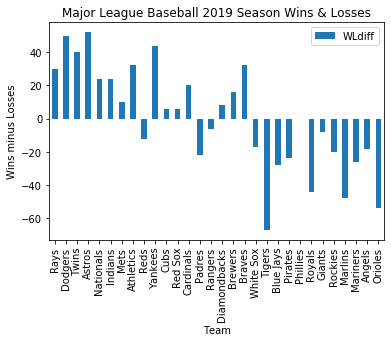

In [490]:
(teams_
      .plot(kind='bar', title='Major League Baseball 2019 Season Wins & Losses')
      .set_ylabel('Wins minus Losses'));

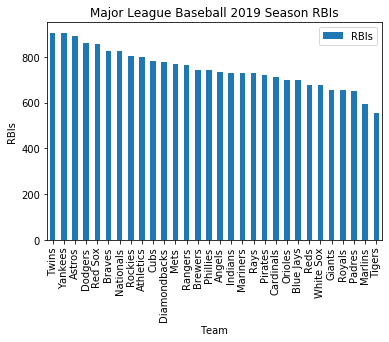

In [491]:
(teams3_
      .plot(kind='bar', title='Major League Baseball 2019 Season RBIs')
      .set_ylabel('RBIs'));

Do you see how Twins, Yankees, Astros, and Dodgers scored many RBIs and also figure on top in the Wins - Losses board? But who's ***right after them***, with *almost the same amount of RBIs*, and yet is *not* playing in this posteason?

</br >
<center>
<img src="ipynb.images/redsox.jpg" width=200 />
</center>

So although the Red Sox was a power hitting team, their **defense** and/or their **coaching**/game-strategy was ***sub-par***. In the end, it's **Wins** minus **Losses** that takes you to the post-season, not RBIs.

## Building a Bayesian Model: The Priors

We know that a count outcome is most often modelled as a Poisson distribution. We will model **effective** team strength as $y$ as a Poisson distribution: $(y\;|\;θ_j) \propto Poisson(θ_j)$ where the $\theta_j$ parameters represent team attacking (OPS and WAR) and defensive parameters (BABIP and FIP).

Instead of considering the OPS and WAR of each batter, and the BABIP and FIP of each hitter, we'll simplify and consider only the top 5 batters in the [batting order](https://en.wikipedia.org/wiki/Batting_order_(baseball), and the top 5 starting pitchers in the [pitching rotation](https://en.wikipedia.org/wiki/Starting_pitcher).

We aren't even considering the **bullpen pitchers** (closers), who make ***such a huge difference in the last 3 innings***!

So how many prior parameters in total? **5 \* 2 + 5 \* 2 = 20 per team**. For 30 teams, this is a total of ***600 model parameters***!

We will model our ***per-team*** $\theta$ as an exponential of **twenty** independent variables: two attack variables **att** for each of the top 5 batters, and two defense variables **def** for each of the top 5 pitchers, times a constant factor k. We won't base this on a ***per game***/played (e.g. $att_g$) model as we did with football (although we could have, but then maybe we have so many more model parameters that we probably need to run on AWS), but on a ***per team***/season model (e.g. $att_t$).

Let's assume the index $b$ for batters (attack), and $p$ for pitchers (defense). 

$$θ = k * \Pi_be^{\text{att1}_b} * \Pi_be^{\text{att2}_b} * \Pi_pe^{\text{def1}_p} * \Pi_pe^{\text{def2}_p}$$

Our priors are thus modeled with a **log-linear** random effect model, a common procedure in sports analytics. 

$$\log(θ) = \text{intercept} + \sum_b\text{att1}_b + \sum_b\text{att2}_b + \sum_p\text{def1}_p + \sum_p\text{def2}_p$$

For each team $t = 1, \cdots, T$, team-specific attack and defense effects are modelled from normal distributions:
$att1_b \propto \text{Normal}(μ_{att1},τ_{att1})$, $att2_b \propto \text{Normal}(μ_{att2},τ_{att2})$, and $def1_p \propto \text{Normal}(μ_{def1}, τ_{def1})$, $def2_p \propto \text{Normal}(μ_{def2}, τ_{def2})$.

To further simplify, we'll set $τ_{att2} = τ_{att1}$ and $τ_{def2} = τ_{def1}$.

We now build a model in `PyMC3`, specifying global parameters, team-specific parameters, and likelihood function.

# On 2nd thought..

This model *may* work, but it's the ***wrong start***. Too complex for a start. We need to take baby steps!

</br >
<center>
<img src="ipynb.images/baby-steps.png" width=400 />
</center>

So wjat we'll do is to ***sum*** the attack & defense factors we picked from the top-5 pitchers and batters. Since `fangraphs` is throttling our requests, we'll just get as many players from each team as we can.

Batters:
- WAR
- OBS = OBP + SLG

Pitchers:
- BABIF
- FIP

## Batters

In [492]:
players_batting_war = players_batting[['Name', 'Team', 'WAR']]
players_batting_war.head()

Name       Team  WAR
1        Mike Trout     Angels  8.6
2      Alex Bregman     Astros  8.5
3  Christian Yelich    Brewers  7.8
4    Cody Bellinger    Dodgers  7.8
5     Marcus Semien  Athletics  7.6

In [493]:
players_batting_war.groupby(['Team'])['WAR'].agg('sum')

Team
- - -              2.81.91.51.41.21.0
Angels                  8.63.42.5-0.4
Astros             8.56.54.23.53.21.0
Athletics            7.66.13.91.3-1.0
Blue Jays                      0.50.4
Braves                5.64.94.64.01.5
Brewers           7.85.22.81.91.5-0.4
Cardinals             4.13.72.92.61.5
Cubs                  4.84.44.02.61.9
Diamondbacks         7.13.72.42.2-0.1
Dodgers               7.84.83.43.33.0
Giants                      2.00.50.4
Indians                  4.44.43.31.1
Mariners                    1.60.00.0
Marlins                     3.11.91.3
Mets                  4.84.63.72.71.4
Nationals             7.04.83.52.52.3
Orioles                  4.03.61.90.6
Padres                        3.1-0.4
Phillies              5.74.62.32.21.7
Pirates            3.23.02.52.42.20.1
Rangers                  1.91.71.40.3
Rays                     4.03.32.81.8
Red Sox         6.86.65.93.53.22.01.4
Reds                        4.51.60.7
Rockies                  5.95.82.00.6
Royals 

Hmm.. Why are we getting averages as string concatenations? Can you guess?

<div style="display:none;">
Because WARs are listed as string types! So let's convert them to floats!
</div>

In [494]:
players_batting['WARs'] = players_batting['WAR'].astype(float) 
players_batting_war = players_batting[['Name', 'Team', 'WARs']]
players_batting_war.head()

Name       Team  WARs
1        Mike Trout     Angels   8.6
2      Alex Bregman     Astros   8.5
3  Christian Yelich    Brewers   7.8
4    Cody Bellinger    Dodgers   7.8
5     Marcus Semien  Athletics   7.6

In [495]:
wars = players_batting_war.groupby(['Team'])['WARs'].agg('sum')
wars

Team
- - -            9.8
Angels          14.1
Astros          26.9
Athletics       17.9
Blue Jays        0.9
Braves          20.6
Brewers         18.8
Cardinals       14.8
Cubs            17.7
Diamondbacks    15.3
Dodgers         22.3
Giants           2.9
Indians         13.2
Mariners         1.6
Marlins          6.3
Mets            17.2
Nationals       20.1
Orioles         10.1
Padres           2.7
Phillies        16.5
Pirates         13.4
Rangers          5.3
Rays            11.9
Red Sox         29.4
Reds             6.8
Rockies         14.3
Royals          10.8
Tigers          -0.3
Twins           13.9
White Sox       15.3
Yankees         14.3
Name: WARs, dtype: float64

Let's get rid of the empty team row (first row above):

In [496]:
wars = wars[1:]
wars

Team
Angels          14.1
Astros          26.9
Athletics       17.9
Blue Jays        0.9
Braves          20.6
Brewers         18.8
Cardinals       14.8
Cubs            17.7
Diamondbacks    15.3
Dodgers         22.3
Giants           2.9
Indians         13.2
Mariners         1.6
Marlins          6.3
Mets            17.2
Nationals       20.1
Orioles         10.1
Padres           2.7
Phillies        16.5
Pirates         13.4
Rangers          5.3
Rays            11.9
Red Sox         29.4
Reds             6.8
Rockies         14.3
Royals          10.8
Tigers          -0.3
Twins           13.9
White Sox       15.3
Yankees         14.3
Name: WARs, dtype: float64

And let's rescale since the WAr numbers are so much higher than the other factors.

In [497]:
from sklearn import preprocessing
nwars = preprocessing.scale(wars) + 2
nwars

array([2.12766291, 3.87846848, 2.64743331, 0.32214466, 3.01674386,
       2.77053683, 2.22341009, 2.62007697, 2.29180093, 3.24927273,
       0.59570803, 2.00455939, 0.41789184, 1.06076576, 2.55168613,
       2.94835302, 1.58053616, 0.56835169, 2.45593895, 2.03191573,
       0.92398407, 1.8267432 , 4.22042269, 1.1291566 , 2.15501924,
       1.67628334, 0.15800664, 2.10030657, 2.29180093, 2.15501924])

In [498]:
list(nwars)

[2.1276629064071564,
 3.878468479991017,
 2.647433311064865,
 0.3221446586488006,
 3.016743861742711,
 2.7705368279574802,
 2.2234100862125237,
 2.6200769739776173,
 2.291800928930644,
 3.2492727269843176,
 0.5957080295212787,
 2.0045593895145415,
 0.41789183845416766,
 1.0607657600044915,
 2.551686131259497,
 2.9483530190245912,
 1.5805361646622003,
 0.568351692434031,
 2.4559389514541303,
 2.031915726601789,
 0.9239840745682524,
 1.8267431984474305,
 4.2204226935816145,
 1.129156602722611,
 2.1550192434944044,
 1.6762833444675675,
 0.1580066361253134,
 2.1003065693199083,
 2.291800928930644,
 2.1550192434944044]

In [ ]:
wars = players_batting_war.groupby(['Team'])['WARs'].agg('sum')
wars

Now for OPS:

In [499]:
players_batting['OPS'] = players_batting['OBP'].astype(float) + players_batting['SLG'].astype(float)
players_batting_ops = players_batting[['Name', 'Team', 'OPS']]
players_batting_ops.head()

Name       Team    OPS
1        Mike Trout     Angels  1.083
2      Alex Bregman     Astros  1.015
3  Christian Yelich    Brewers  1.100
4    Cody Bellinger    Dodgers  1.035
5     Marcus Semien  Athletics  0.891

In [500]:
opss = players_batting_ops.groupby(['Team'])['OPS'].agg('sum')
opss

Team
- - -           4.705
Angels          3.344
Astros          5.379
Athletics       4.026
Blue Jays       1.509
Braves          4.320
Brewers         4.971
Cardinals       3.927
Cubs            4.317
Diamondbacks    4.116
Dodgers         4.500
Giants          2.158
Indians         3.285
Mariners        2.185
Marlins         2.256
Mets            4.235
Nationals       4.347
Orioles         3.213
Padres          1.531
Phillies        4.005
Pirates         4.964
Rangers         3.112
Rays            3.272
Red Sox         6.019
Reds            2.423
Rockies         3.598
Royals          3.345
Tigers          0.744
Twins           3.527
White Sox       4.768
Yankees         3.435
Name: OPS, dtype: float64

In [501]:
opss = opss[1:]
opss

Team
Angels          3.344
Astros          5.379
Athletics       4.026
Blue Jays       1.509
Braves          4.320
Brewers         4.971
Cardinals       3.927
Cubs            4.317
Diamondbacks    4.116
Dodgers         4.500
Giants          2.158
Indians         3.285
Mariners        2.185
Marlins         2.256
Mets            4.235
Nationals       4.347
Orioles         3.213
Padres          1.531
Phillies        4.005
Pirates         4.964
Rangers         3.112
Rays            3.272
Red Sox         6.019
Reds            2.423
Rockies         3.598
Royals          3.345
Tigers          0.744
Twins           3.527
White Sox       4.768
Yankees         3.435
Name: OPS, dtype: float64

## Pitchers

In [502]:
players_pitching_babip = players_pitching[['Name', 'Team', 'BABIP']]
players_pitching_babip.head()

Name       Team   BABIP
1       Gerrit Cole     Astros  83.3 %
2      Jacob deGrom       Mets  81.8 %
3        Lance Lynn    Rangers  74.4 %
4      Max Scherzer  Nationals  78.7 %
5  Justin Verlander     Astros  88.4 %

We need to get rid of the trailing ` %`:

In [503]:
def rchop(thestring, ending):
    if thestring.endswith(ending):
        return thestring[:-len(ending)]
    return thestring

#somestring = rchop(somestring, '  %')

In [504]:
players_pitching['BABIP%'] = [float(rchop(b, ' %'))/100. for b in players_pitching['BABIP']]
players_pitching['BABIP%']

1     0.833
2     0.818
3     0.744
4     0.787
5     0.884
6     0.753
7     0.765
8     0.774
9     0.757
10    0.777
11    0.710
12    0.822
13    0.773
14    0.833
15    0.714
16    0.735
17    0.689
18    0.797
19    0.803
20    0.718
21    0.767
22    0.799
23    0.761
24    0.777
25    0.692
26    0.659
27    0.768
28    0.681
29    0.840
30    0.632
31    0.744
32    0.704
33    0.704
34    0.718
35    0.743
36    0.712
37    0.714
38    0.777
39    0.738
40    0.749
41    0.777
42    0.751
43    0.738
44    0.692
45    0.722
46    0.765
47    0.730
48    0.731
49    0.728
50    0.748
51    0.743
52    0.781
53    0.676
54    0.657
55    0.785
56    0.766
57    0.703
58    0.739
59    0.769
60    0.781
61    0.726
Name: BABIP%, dtype: float64

In [505]:
players_pitching_babip = players_pitching[['Name', 'Team', 'BABIP%']]
players_pitching_babip.head()

Name       Team  BABIP%
1       Gerrit Cole     Astros   0.833
2      Jacob deGrom       Mets   0.818
3        Lance Lynn    Rangers   0.744
4      Max Scherzer  Nationals   0.787
5  Justin Verlander     Astros   0.884

In [506]:
babips = players_pitching_babip.groupby(['Team'])['BABIP%'].agg('mean')
babips

Team
- - -           0.740167
Astros          0.820000
Athletics       0.766500
Braves          0.769333
Cardinals       0.779250
Cubs            0.717000
Diamondbacks    0.741000
Dodgers         0.790667
Giants          0.743500
Indians         0.774000
Mariners        0.692000
Marlins         0.738000
Mets            0.740333
Nationals       0.768500
Padres          0.730000
Phillies        0.753500
Pirates         0.632000
Rangers         0.773500
Rays            0.753000
Red Sox         0.717000
Reds            0.780333
Rockies         0.681000
Royals          0.712500
Tigers          0.744000
Twins           0.705500
White Sox       0.732333
Yankees         0.704000
Name: BABIP%, dtype: float64

In [507]:
babips = babips[1:]
babips

Team
Astros          0.820000
Athletics       0.766500
Braves          0.769333
Cardinals       0.779250
Cubs            0.717000
Diamondbacks    0.741000
Dodgers         0.790667
Giants          0.743500
Indians         0.774000
Mariners        0.692000
Marlins         0.738000
Mets            0.740333
Nationals       0.768500
Padres          0.730000
Phillies        0.753500
Pirates         0.632000
Rangers         0.773500
Rays            0.753000
Red Sox         0.717000
Reds            0.780333
Rockies         0.681000
Royals          0.712500
Tigers          0.744000
Twins           0.705500
White Sox       0.732333
Yankees         0.704000
Name: BABIP%, dtype: float64

In [508]:
len(babips)

26

In [509]:
players_pitching['FIPs'] = players_pitching['FIP'].astype(float)
players_pitching_fip = players_pitching[['Name', 'Team', 'FIPs']]
players_pitching_fip.head()

Name       Team  FIPs
1       Gerrit Cole     Astros  2.48
2      Jacob deGrom       Mets  3.11
3        Lance Lynn    Rangers  3.85
4      Max Scherzer  Nationals  2.88
5  Justin Verlander     Astros  3.18

In [510]:
fips = players_pitching_fip.groupby(['Team'])['FIPs'].agg('mean')
fips

Team
- - -           4.315000
Astros          3.393333
Athletics       4.990000
Braves          4.143333
Cardinals       4.190000
Cubs            4.050000
Diamondbacks    4.170000
Dodgers         3.396667
Giants          4.665000
Indians         3.230000
Mariners        5.110000
Marlins         5.170000
Mets            3.666667
Nationals       3.685000
Padres          4.360000
Phillies        4.290000
Pirates         4.310000
Rangers         4.225000
Rays            3.280000
Red Sox         4.620000
Reds            3.810000
Rockies         3.540000
Royals          4.785000
Tigers          3.880000
Twins           4.505000
White Sox       4.613333
Yankees         4.290000
Name: FIPs, dtype: float64

In [511]:
fips = fips[1:]
fips

Team
Astros          3.393333
Athletics       4.990000
Braves          4.143333
Cardinals       4.190000
Cubs            4.050000
Diamondbacks    4.170000
Dodgers         3.396667
Giants          4.665000
Indians         3.230000
Mariners        5.110000
Marlins         5.170000
Mets            3.666667
Nationals       3.685000
Padres          4.360000
Phillies        4.290000
Pirates         4.310000
Rangers         4.225000
Rays            3.280000
Red Sox         4.620000
Reds            3.810000
Rockies         3.540000
Royals          4.785000
Tigers          3.880000
Twins           4.505000
White Sox       4.613333
Yankees         4.290000
Name: FIPs, dtype: float64

In [512]:
len(fips)

26

In [513]:
mlb_teams = fips.index
mlb_teams

Index(['Astros', 'Athletics', 'Braves', 'Cardinals', 'Cubs', 'Diamondbacks',
       'Dodgers', 'Giants', 'Indians', 'Mariners', 'Marlins', 'Mets',
       'Nationals', 'Padres', 'Phillies', 'Pirates', 'Rangers', 'Rays',
       'Red Sox', 'Reds', 'Rockies', 'Royals', 'Tigers', 'Twins', 'White Sox',
       'Yankees'],
      dtype='object', name='Team')

In [ ]:
len(mlb_teams)

In [514]:
new_num_teams = len(mlb_teams)
new_num_teams

26

In [515]:
teams_

WLdiff
Team                
Rays              30
Dodgers           50
Twins             40
Astros            52
Nationals         24
Indians           24
Mets              10
Athletics         32
Reds             -12
Yankees           44
Cubs               6
Red Sox            6
Cardinals         20
Padres           -22
Rangers           -6
Diamondbacks       8
Brewers           16
Braves            32
White Sox        -17
Tigers           -67
Blue Jays        -28
Pirates          -24
Phillies           0
Royals           -44
Giants            -8
Rockies          -20
Marlins          -48
Mariners         -26
Angels           -18
Orioles          -54

We started off with 30 teams with our batter, and now we're down to 26 for pitchers. What happened? Probably because we did not get all the pitchers from `fangraphs`. Let's hack around this and reduce the number of teams in our batters lists.

In [516]:
teams4 = teams_.reindex(mlb_teams)
teams4

WLdiff
Team                
Astros            52
Athletics         32
Braves            32
Cardinals         20
Cubs               6
Diamondbacks       8
Dodgers           50
Giants            -8
Indians           24
Mariners         -26
Marlins          -48
Mets              10
Nationals         24
Padres           -22
Phillies           0
Pirates          -24
Rangers           -6
Rays              30
Red Sox            6
Reds             -12
Rockies          -20
Royals           -44
Tigers           -67
Twins             40
White Sox        -17
Yankees           44

In [517]:
teams4.values

array([[ 52],
       [ 32],
       [ 32],
       [ 20],
       [  6],
       [  8],
       [ 50],
       [ -8],
       [ 24],
       [-26],
       [-48],
       [ 10],
       [ 24],
       [-22],
       [  0],
       [-24],
       [ -6],
       [ 30],
       [  6],
       [-12],
       [-20],
       [-44],
       [-67],
       [ 40],
       [-17],
       [ 44]])

We create new `wars2` and `opss2` factors to reflect our team reduction:

In [518]:
wars2 = wars.reindex(mlb_teams)
wars2

Team
Astros          26.9
Athletics       17.9
Braves          20.6
Cardinals       14.8
Cubs            17.7
Diamondbacks    15.3
Dodgers         22.3
Giants           2.9
Indians         13.2
Mariners         1.6
Marlins          6.3
Mets            17.2
Nationals       20.1
Padres           2.7
Phillies        16.5
Pirates         13.4
Rangers          5.3
Rays            11.9
Red Sox         29.4
Reds             6.8
Rockies         14.3
Royals          10.8
Tigers          -0.3
Twins           13.9
White Sox       15.3
Yankees         14.3
Name: WARs, dtype: float64

In [520]:
nwars2 = nwars.reindex(mlb_teams)
nwars2

AttributeError: 'list' object has no attribute 'reindex'

In [521]:
opss2 = opss.reindex(mlb_teams)
opss2

Team
Astros          5.379
Athletics       4.026
Braves          4.320
Cardinals       3.927
Cubs            4.317
Diamondbacks    4.116
Dodgers         4.500
Giants          2.158
Indians         3.285
Mariners        2.185
Marlins         2.256
Mets            4.235
Nationals       4.347
Padres          1.531
Phillies        4.005
Pirates         4.964
Rangers         3.112
Rays            3.272
Red Sox         6.019
Reds            2.423
Rockies         3.598
Royals          3.345
Tigers          0.744
Twins           3.527
White Sox       4.768
Yankees         3.435
Name: OPS, dtype: float64

## Building a Bayesian Model: The Likelihood 

Ok, we have what we think (if our model is correct) **team priors** for **attack** and **defense** in baseball. Now let's specity our likelihood function in `pymc3`. 

We know that whenever we have a small number of data point (about 30 or less), the [t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) gives better results than the normal distribution. 

The **half-t distribution** (also denoted **folded-t**) is derived from the t-distribution by taking the absolute values of variates. Since we already know the sign of `att` and `def` parameters, we don't want any negative signs. I will use the half student-t distribution to model standard deviations, but I will start my model building with normal distributions for the priors. If I get bad results, I may have to come back here and replace with student-t's instead.

Since we have a linear model for log$\theta$, we have a *slope-intercept* formula: $y = mx + b$ where $m$ is the slope or the consistent change between $x$ and $y$, and $b$ is the y-intercept (intercepts the y-axis at $y = b$). It is the expected mean value of $y$ when $x = 0$.

# Model 1: A loose model

A log-linear model with loose normal pdf priors where the log of the Poisson paramater is a linear combination of the priors (plus a bias).

To see if our offense and defense factors are appropriate for the model, run a trace and see if the posteriors redistribute the means or if they stay a the same positions.

We'll specify a full model, and then immediately simplify it.

Here's the ***full*** model in `pymc3` (we ***won't*** run this):

In [ ]:
num_teams

In [ ]:
batters = range(0, 5)
pitchers = range(0, 5)

In [ ]:
import pymc3 as pm, theano.tensor as tt

with pm.Model() as model:
    # GLOBAL model priors: standard deviation and intercept.
    # We are saying that the standard deviation and intercept priors of each
    # team's att and def parameters stem from the same folded-t distribution.
    # Note use of student-t because we only have 30 teams, low number.
    # Note mean and standard deviation for our priors, picked from a hat like a rabbit!
    sd_att = pm.HalfStudentT('sd_att', nu=3, sd=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sd=2.5)
    intercept = pm.Flat('intercept') #no idea

    # TEAM-specific model parameters. There are five (att1s_star, att2s_star) tuples per team (one for each top-5 batter),
    # and five (def1s_star, def2s_star) tuples per team (one for each top-5 pitcher). Thus, 20 priors per team! We have 30
    # teams, so that's 600 parameters for our model!!
    # Note use of normal distribution because we assume we have a lot of data per team
    att1s_star = pm.Normal("att1s_star", mu=wars2, sd=sd_att, shape=num_teams * len(batters))
    att2s_star = pm.Normal("att2s_star", mu=opss2, sd=sd_att, shape=num_teams * len(batters))
    def1s_star = pm.Normal("def1s_star", mu=babips sd=sd_def, shape=num_teams * len(pitchers))
    def2s_star = pm.Normal("def2s_star", mu=fips, sd=sd_def, shape=num_teams * len(pitchers))

    # To allow samples of expressions to be saved, we need to wrap them in pymc3 Deterministic objects
    # We save these parameters for later exploration.
    att1s = pm.Deterministic('att1s', att1s_star - tt.mean(att1s_star))
    att2s = pm.Deterministic('att2s', att2s_star - tt.mean(att2s_star))
    def1s = pm.Deterministic('def1s', def1s_star - tt.mean(def1s_star))
    def2s = pm.Deterministic('def2s', def2s_star - tt.mean(def2s_star))
    
    # Assume exponential search on theta and away_theta. We're relying on theano. No idea what to do when theano goes away..
    theta = tt.exp(intercept + 
                   att1s[mlb_teams_by_rbis_index][batters] + 
                   att1s[mlb_teams_by_rbis_index][batters] + 
                   def1s[mlb_teams_by_rbis_index][pitchers] + 
                   def2s[mlb_teams_by_rbis_index][pitchers])  

    # likelihood of observed data, Poisson distribution for count data
    wins = pm.Poisson('wins', mu=theta, observed=observed_wins_losses)

In [ ]:
num_teams

In [ ]:
mlb_teams_by_rbis_index

In [ ]:
observed_wins_losses

Here's our ***simplified*** model:

In [522]:
len(wars2), len(opss2), len(babips), len(fips), new_num_teams

(26, 26, 26, 26, 26)

In [523]:
mlb_teams_by_rbis_index_2 = range(0, 26)
mlb_teams_by_rbis_index_2

range(0, 26)

In [ ]:
import pymc3 as pm, theano.tensor as tt

with pm.Model() as model:
    # GLOBAL model priors: standard deviation and intercept.
    # We are saying that the standard deviation and intercept priors of each
    # team's att and def parameters stem from the same folded-t distribution.
    # Note use of student-t because we only have 30 teams, low number.
    # Note mean and standard deviation for our priors, picked from a hat like a rabbit!
    sd_att = pm.HalfStudentT('sd_att', nu=3, sd=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sd=2.5)
    intercept = pm.Flat('intercept') #no idea

    # TEAM-specific model parameters. There is one (att1s_star, att2s_star) tuple per team,
    # and one (def1s_star, def2s_star) tuple per team. Thus, 4 priors per team! We have 30
    # teams, so that's 120 parameters for our model!!
    # Note use of normal distribution because we assume we have a lot of data per team
    att1s_star = pm.Normal("att1s_star", mu=wars2, sd=sd_att, shape=new_num_teams)
    att2s_star = pm.Normal("att2s_star", mu=opss2, sd=sd_att, shape=new_num_teams)
    def1s_star = pm.Normal("def1s_star", mu=babips, sd=sd_def, shape=new_num_teams)
    def2s_star = pm.Normal("def2s_star", mu=fips, sd=sd_def, shape=new_num_teams)

    # To allow samples of expressions to be saved, we need to wrap them in pymc3 Deterministic objects
    # We save these parameters for later exploration.
    att1s = pm.Deterministic('att1s', att1s_star - tt.mean(att1s_star))
    att2s = pm.Deterministic('att2s', att2s_star - tt.mean(att2s_star))
    def1s = pm.Deterministic('def1s', def1s_star - tt.mean(def1s_star))
    def2s = pm.Deterministic('def2s', def2s_star - tt.mean(def2s_star))
    
    # Assume exponential search on theta and away_theta. We're relying on theano. No idea what to do when theano goes away..
    theta = tt.exp(intercept + 
                   att1s[mlb_teams_by_rbis_index_2] + 
                   att1s[mlb_teams_by_rbis_index_2] + 
                   def1s[mlb_teams_by_rbis_index_2] + 
                   def2s[mlb_teams_by_rbis_index_2])  

    # likelihood of observed data, Poisson distribution for count data
    wins = pm.Poisson('wins', mu=theta, observed=teams4.values)

So let's think this through. We have `att1s_star`, `att2s_star`, `def1s_star`, `def1s_star` priors that are **very loosely specified** (just initial mean of our offense and defense point estimates) offense and defense ***normal pdfs***. If these priors are good models, then our posteriors should reflect this. That means our distributions will sharpen (smaller standard deviations), but the means should not redistribute as we converge in our simulation. If they do, that could mean that our model parameter choice may be overly ***simplistic***. 

</br >
<center>
<img src="ipynb.images/allright.gif" width=300 />
</center>

Allright allright allright! We have our model.

A *trace* is a MCMC sampling of your **posterior** probability distribution: the shape of your priors after matching them to our observations of the 2019 season. This yields the parameters for our model (`att` and `def` per team, for a log-linear model consisting of the top-5 batters and the top-5 pitchers) that are ***most likely to fit our observations***. 

We won't specify an algorithm. PyMC3 will most likely choose NUTS. Our parameter space is 600-dimensional! How long do you think this trace will take? Will it fry my kernel?

</br >
<center>
<img src="ipynb.images/dastardly.png" width=300 />
</center>

In [ ]:
with model:
    trace = pm.sample(1000, tune=1000, cores=2)
    pm.traceplot(trace)

# Model 2: A tighter model

We model a ***team*** **power** stochastic variable $\lambda$ as a linear model of our offense and defense parameters:

$$\lambda_{i} = \alpha_{0i} + \alpha_{1i}(wars)_{i} + \alpha_{2i}(ops)_{i}  + \beta_{1i}(babips)_{i} + \beta_{2i}(fips)_{i}$$

Priors are now $\alpha_{0i}$, $\alpha_{1i}$, $\alpha_{2i}$, $\beta_{1i}$, $\beta_{2i}$, for $i$ in 0, .., $N$ teams, expressed as pdfs.

And we model our likelihood as a poisson distribution based on win/loss differentials:

$$\text{likelihood}_t = \text{Poisson}(\lambda_t,τ_t)$$

We then use PyMC3 Generalized Linear Model (GLM) syntax ([patsy](https://patsy.readthedocs.io/en/latest/formulas.html) style). It's this expression, which says that we want win/loss differential to be a linear combination of the other variables: `win-loss ~ wars + ops + babips + fips`.

In [524]:
with pm.Model() as glm_model:
    pm.glm.GLM.from_formula('WL ~ WARs + OPS + BABIP% + FIPs',
                            data,
                            family=pm.glm.families.Poisson())
    trace = pm.sample(1000, tune=1000, init='adapt_diag')

SyntaxError: invalid syntax (<unknown>, line 1)

So now we need to create our `data` dataframe:

In [526]:
data = pd.concat([wars2, opss2, babips, fips], axis=1)
data

WARs    OPS    BABIP%      FIPs
Team                                         
Astros        26.9  5.379  0.820000  3.393333
Athletics     17.9  4.026  0.766500  4.990000
Braves        20.6  4.320  0.769333  4.143333
Cardinals     14.8  3.927  0.779250  4.190000
Cubs          17.7  4.317  0.717000  4.050000
Diamondbacks  15.3  4.116  0.741000  4.170000
Dodgers       22.3  4.500  0.790667  3.396667
Giants         2.9  2.158  0.743500  4.665000
Indians       13.2  3.285  0.774000  3.230000
Mariners       1.6  2.185  0.692000  5.110000
Marlins        6.3  2.256  0.738000  5.170000
Mets          17.2  4.235  0.740333  3.666667
Nationals     20.1  4.347  0.768500  3.685000
Padres         2.7  1.531  0.730000  4.360000
Phillies      16.5  4.005  0.753500  4.290000
Pirates       13.4  4.964  0.632000  4.310000
Rangers        5.3  3.112  0.773500  4.225000
Rays          11.9  3.272  0.753000  3.280000
Red Sox       29.4  6.019  0.717000  4.620000
Reds           6.8  2.423  0.780333  3.810000
Rockies       14.3  3.598  0.681000  3.540000
Royals        10.8  3.345  0.712500  4.785000
Tigers        -0.3  0.744  0.744000  3.880000
Twins         13.9  3.527  0.705500  4.505000
White Sox     15.3  4.768  0.732333  4.613333
Yankees       14.3  3.435  0.704000  4.290000

oops.. need to replace `wars` with `nwars`!

Also, we need to tack on the win/loss column (with reduced team dataset):

In [527]:
data['WL'] = teams4.values
data

WARs    OPS    BABIP%      FIPs  WL
Team                                             
Astros        26.9  5.379  0.820000  3.393333  52
Athletics     17.9  4.026  0.766500  4.990000  32
Braves        20.6  4.320  0.769333  4.143333  32
Cardinals     14.8  3.927  0.779250  4.190000  20
Cubs          17.7  4.317  0.717000  4.050000   6
Diamondbacks  15.3  4.116  0.741000  4.170000   8
Dodgers       22.3  4.500  0.790667  3.396667  50
Giants         2.9  2.158  0.743500  4.665000  -8
Indians       13.2  3.285  0.774000  3.230000  24
Mariners       1.6  2.185  0.692000  5.110000 -26
Marlins        6.3  2.256  0.738000  5.170000 -48
Mets          17.2  4.235  0.740333  3.666667  10
Nationals     20.1  4.347  0.768500  3.685000  24
Padres         2.7  1.531  0.730000  4.360000 -22
Phillies      16.5  4.005  0.753500  4.290000   0
Pirates       13.4  4.964  0.632000  4.310000 -24
Rangers        5.3  3.112  0.773500  4.225000  -6
Rays          11.9  3.272  0.753000  3.280000  30
Red Sox       29.4  6.019  0.717000  4.620000   6
Reds           6.8  2.423  0.780333  3.810000 -12
Rockies       14.3  3.598  0.681000  3.540000 -20
Royals        10.8  3.345  0.712500  4.785000 -44
Tigers        -0.3  0.744  0.744000  3.880000 -67
Twins         13.9  3.527  0.705500  4.505000  40
White Sox     15.3  4.768  0.732333  4.613333 -17
Yankees       14.3  3.435  0.704000  4.290000  44

*etc* :-)